# Genome-scale reconstruction workflow

This notebook serves as a step-by-step workflow for improving or reconstructing metabolic models and showcasing the functionality of the MetMod library.

It is a part of a bachelor's thesis, where the theoretical aspects of metabolic model reconstruction are introduced and discussed.

## 0. Dependencies and setup

We recommend using Python 3.9 as this version's functionality has been tested.

The following libraries are required:
* cobra, escher, networkx, matplotlib, XlsxWriter, pandas, numpy, openpyxl

Additional:
* ModelPolisher, efmtool, Cplex
* libsbml - https://sbml.org/software/libsbml/libsbml-docs/installation/

If there are any problems with Escher visualisation, refer to https://escher.readthedocs.io/en/latest/escher-python.html#Installation, as further Jupyter extensions may be required. When using a conda environment, make sure Jupyter is installed inside it. These commands worked when testing:
* jupyter labextension install @jupyter-widgets/jupyterlab-manager
* jupyter labextension install escher

We recommend using the academic or commercial license of Cplex for optimisation; the free version will not work due to the size of metabolic models.

Using a Conda environment is encouraged; the following cell contains commands tested to create a Conda environment and enable Escher visualisation within a Jupyter notebook.

In [ ]:
# conda create --name metmod-test python=3.9 -y
# conda activate metmod-test
# conda install pip -y
# conda install jupyter
# pip install escher notebook
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
# jupyter labextension install escher

Run the following cell in order to install dependencies

In [ ]:
%pip install cobra escher networkx git+https://github.com/draeger-lab/MPClient.git matplotlib xlsxwriter pandas numpy efmtool openpyxl

In [1]:
import cobra, escher, libsbml, os
import numpy as np
import matplotlib as plt
import networkx as nx
import metmod

In [ ]:
model_name = 'core'

In [ ]:
# Some models created by automated tools will have some issues, like not having flux bounds set
# correctly, in order to suppress warnings run this cell
import logging

logging.getLogger('cobra').setLevel(logging.ERROR)

## 1. Draft reconstruction

A draft reconstruction is expected as input; we recommend using an automated software designed for this purpose, such as PathwayTools - PathoLogic or CarveMe.

### Standardising nomenclature

ModelPolisher is used in order to standardise and polish annotations of the draft reconstruction.

**NOTE** polishing bigger models (>1000 reactions) may take up to few minutes

In [ ]:
input_path = os.path.join('input', 'caldimonas_core_model.xml')

In [ ]:
polished_path = os.path.join('models', f'{model_name}_polished.xml')

In [ ]:
# metmod.polish_model(input_path, polished_path, print_diff=True)

In [6]:
# During the creation of this notebook, ModelPolisher had server connection issues
# for multiple days, the curated model has therefore not been polished
polished_path = input_path

## 2. First assessment

In the section we will take a first look at the draft reconstruction. We highly encourage the use of Cytoscape for this step.

### Escher

While Escher does not provide a way to visualise the entire network, it allows for easy mapping of the model to an existing visualisation.

However, the IDs in the model must match the IDs in the map, depending on the software used for draft reconstruction **this approach may not work**.

In [7]:
# The available maps are listed by the following command.
escher.list_available_maps()

[{'organism': 'Saccharomyces cerevisiae',
  'map_name': 'iMM904.Central carbon metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Inositol retinol metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Glycolysis TCA PPP'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Tryptophan metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Carbohydrate metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Amino acid metabolism (partial)'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Nucleotide metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid biosynthesis (saturated)'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Nucleotide and histidine biosynthesis'},
 {'organism': 'Escherichia coli', 'map_name': 'e_coli_core.Core metabolism'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Central metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid beta-oxidation'}

In [ ]:
map_path = os.path.join('maps', 'caldimonas_core_map.json')

Escher provides a Builder class where all settings are configured. Here we use an existing map with our model.

In [9]:
metmod.escher_build(polished_path, map_path, highlight_missing=True)

Builder(highlight_missing=True)

Reactions highlighted in red are missing from the model; however note that this may also be the cause of using different nomenclature.

### Topology analysis

NetworkX is used for graph algorithms, some wrappers are present in MetMod.

In [10]:
model = cobra.io.read_sbml_model(polished_path)

Firstly, a function that creates a directed G graph is called.

In [11]:
G = metmod.create_metabolic_graph(model)

In [12]:
# Print out nodes sorted by node degree (+reversed)
metmod.print_degree_sorted(G)

Highest degree nodes:
[('Biomass_putida_core_2', 79), ('Biomass', 64), ('h_c', 52), ('h2o_c', 35), ('atp_c', 27), ('adp_c', 26), ('pi_c', 24), ('Biomass_ecoli_core', 23), ('nad_c', 22), ('nadh_c', 21), ('coa_c', 17), ('g3p_c', 14), ('pyr_c', 14), ('GLUDxi', 14), ('GLUDy', 14), ('nadp_c', 12), ('ACALD', 12), ('ATPS4rpp', 12), ('GAPD', 12), ('SUCOAS', 12), ('accoa_c', 11), ('glu__L_c', 11), ('h_p', 11), ('nadph_c', 11), ('nh4_c', 11), ('pep_c', 11), ('co2_c', 10), ('ALCD2x', 10), ('ICDHyr', 10), ('MDH', 10), ('LDH_L', 10), ('PHAb', 10), ('f6p_c', 9), ('q8h2_c', 9), ('akg_c', 8), ('mal__L_c', 8), ('q8_c', 8), ('GAD2ktpp', 8), ('PGK', 8), ('PTAr', 8), ('TALA', 8), ('TKT1', 8), ('TKT2', 8), ('gln__L_c', 7), ('h2o_p', 7), ('xu5p__D_c', 7), ('PPS', 7), ('GLCabc', 7), ('GLNabc', 7), ('GLNabcpp', 7), ('GLNS', 7), ('GLUabc', 7), ('XYLabc', 7), ('XYLabcpp', 7), ('co2_p', 6), ('dhap_c', 6), ('nh4_e', 6), ('oaa_c', 6), ('succ_c', 6), ('ACONTa', 6), ('ACONTb', 6), ('ADK1', 6), ('AKGDH', 6), ('CS', 6

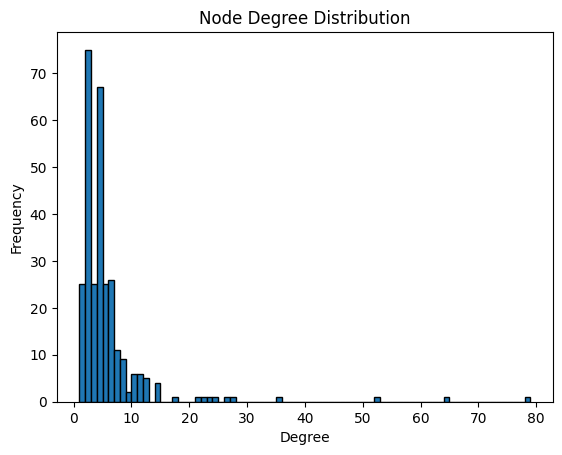

In [13]:
metmod.print_degree_distribution(G)

In [14]:
# Single node strongly connected components are omitted
metmod.print_strongly_connected(G)

2 {'EX_lac__L_e', 'lac__L_e'}
2 {'EX_fum_e', 'fum_e'}
2 {'mal__L_e', 'EX_mal__L_e'}
2 {'EX_pi_e', 'pi_e'}
2 {'succ_e', 'EX_succ_e'}
3 {'CLBtex', 'cellb_e', 'cellb_p'}
3 {'XYLtex', 'xyl__D_e', 'xyl__D_p'}
4 {'EX_for_e', 'for_p', 'for_e', 'FORtex'}
4 {'fru_e', 'FRUtex', 'EX_fru_e', 'fru_p'}
4 {'gln__L_p', 'gln__L_e', 'EX_gln__L_e', 'GLNtex'}
4 {'PYRtex', 'EX_pyr_e', 'pyr_p', 'pyr_e'}
6 {'EX_o2_e', 'o2_p', 'O2tex', 'O2tpp', 'o2_c', 'o2_e'}
181 {'GLNS', '2dhglcn_c', 'adp_c', 'ALCD2x', 'akg_c', 'ACONTa', 'q8h2_c', 'glc__D_p', 'FDH5r2pp', 'GLUDxi', 'h_e', 'PYK', 'ICL', 'focytc_c', 'MALS', 'EX_h_e', 'fum_c', 'GAPD', 'PGI', 'GLUtex', '6pgc_c', 'PHAa', 'etoh_c', 'h_c', 'FRUpts', '2pg_c', 'mqn8_c', 'H2Otpp', 'FUM', 'acald_c', 'GLUNpp', 'accoa_c', 'CS', 'EDD', 'e4p_c', 'nh4_c', 'ENO', 'h2o_e', 'RPI', 'pi_c', 'PTAr', 'nadh_c', 'XYLabcpp', 'co2_c', 'XYLabc', '2DGLCNRx', 'glu__L_e', 'PYRt2rpp', 'glu__L_c', 'GLUabc', '2dhglcn_p', 'GLNabc', 's7p_c', 'glu__L_p', 'mal__L_c', 'TKT1', 'FBP', 'PPCK', 'PIt2

Some helper functions should make it easy to work with the graph, as naming can be unintuitive. Creation of variables instead of relying on strings is encouraged.

In [15]:
# Inspect all node names
# metmod.print_graph_nodes_names()
# Find for names containing a string
metmod.find_graph_names_with(G, 'glu')

['glu__L_c', 'glu__L_e', 'glu__L_p', 'EX_glu__L_e']

In [ ]:
glu = metmod.get_id_by_name(G, 'D-Glucose')
pyr = metmod.get_id_by_name(G, 'Pyruvate')
eno = metmod.get_id_by_name(G, 'Enolase')

In [17]:
metmod.print_neighbors(G, pyr)

PDH
PPS
LDH_L
Biomass_ecoli_core


In [18]:
_, named = metmod.find_paths(G, glu, pyr, [eno], 10, print_path=True)

['D-Glucose', 'Hexokinase (D-glucose:ATP)', 'ADP C10H12N5O10P2', 'ATP synthase (four protons for one ATP) (periplasm)', 'H2O H2O', 'Enolase', 'Phosphoenolpyruvate', 'D-fructose transport via PEP:Pyr PTS (periplasm)', 'Pyruvate']
['D-Glucose', 'Hexokinase (D-glucose:ATP)', 'H+', 'ATP synthase (four protons for one ATP) (periplasm)', 'H2O H2O', 'Enolase', 'Phosphoenolpyruvate', 'D-fructose transport via PEP:Pyr PTS (periplasm)', 'Pyruvate']
['D-Glucose', 'Hexokinase (D-glucose:ATP)', 'H+', 'Glutamate dehydrogenase (NADP)', 'H2O H2O', 'Enolase', 'Phosphoenolpyruvate', 'D-fructose transport via PEP:Pyr PTS (periplasm)', 'Pyruvate']
['D-Glucose', 'Hexokinase (D-glucose:ATP)', 'H+', 'Cytochrome c oxidase aa3  2 protons1 electron    periplasm', 'H2O H2O', 'Enolase', 'Phosphoenolpyruvate', 'D-fructose transport via PEP:Pyr PTS (periplasm)', 'Pyruvate']
['D-Glucose', 'Hexokinase (D-glucose:ATP)', 'H+', 'Glutamate dehydrogenase  NAD', 'H2O H2O', 'Enolase', 'Phosphoenolpyruvate', 'D-fructose tran

In [19]:
# Threshold needs to be tinkered with and set based on degree distribution
# Check if any important nodes were deleted
pruned_G = metmod.prune_graph(G, 30, [pyr])

# Manually delete some nodes
pruned_G = metmod.delete_nodes_by_id(pruned_G, ['adp_c', metmod.get_id_by_name(G, 'Ecoli_core model biomass')])
 
ids, named = metmod.find_paths(pruned_G, glu, pyr, [eno], 10, print_path=True)

Removed 5 nodes with degree greater than 30.
Removed the following nodes: ['H2O H2O', 'H+', 'UDP C9H11N2O12P2', 'Biomass reaction', 'Biomass reaction taken from P. putida IjN1463']
Remaining nodes: 297
['D-Glucose', 'Hexokinase (D-glucose:ATP)', 'D-Glucose 6-phosphate', 'Glucose-6-phosphate isomerase', 'D-Fructose 6-phosphate', 'Transaldolase', 'Glyceraldehyde 3-phosphate', 'Glyceraldehyde-3-phosphate dehydrogenase', '3-Phospho-D-glyceroyl phosphate', 'Phosphoglycerate kinase', '3-Phospho-D-glycerate', 'Phosphoglycerate mutase', 'D-Glycerate 2-phosphate', 'Enolase', 'Phosphoenolpyruvate', 'D-fructose transport via PEP:Pyr PTS (periplasm)', 'Pyruvate']
['D-Glucose', 'Hexokinase (D-glucose:ATP)', 'D-Glucose 6-phosphate', 'Glucose-6-phosphate isomerase', 'D-Fructose 6-phosphate', 'Transketolase', 'Glyceraldehyde 3-phosphate', 'Glyceraldehyde-3-phosphate dehydrogenase', '3-Phospho-D-glyceroyl phosphate', 'Phosphoglycerate kinase', '3-Phospho-D-glycerate', 'Phosphoglycerate mutase', 'D-Glyc

## 3. Iterative workflow

### 3.1 Refinement

Firstly we will create additional files in order to ease manual refinement of model.

In [ ]:
xlsx_path = os.path.join('models', f'{model_name}.xlsx')

In [21]:
model = cobra.io.read_sbml_model(polished_path)
# Create a xlsx file from cobra model
metmod.cobra_to_xlsx(model, xlsx_path)

Model saved to models/core.xlsx


In [ ]:
# Sync xlsx file with SBML and json
metmod.sync_xlsx(xlsx_path, os.path.join('models', model_name), save_json=False)

Saved


In [ ]:
# Optionally load a cobra model from xlsx
model = metmod.xlsx_to_cobra(xlsx_path, model_name)

Additionally, for working with Escher maps and creating a core model, a function which deletes all compounds not present in a map is available. 

In [ ]:
metmod.mini_model_prune(map_path, polished_path, f'mini_{model_name}')
mini_model_path = f'mini_{model_name}.xml'

### 3.2 Cross checking

#### Flux Balance Analysis

Make sure the model has an objective function.

In [23]:
print(model.objective)          # Shows the symbolic expression
print(model.objective.expression)  # Explicit formula (reaction * coefficient)
print(model.objective.direction)   # 'max' or 'min'

Maximize
1.0*Biomass - 1.0*Biomass_reverse_57a34
1.0*Biomass - 1.0*Biomass_reverse_57a34
max


In [ ]:
# If the model contains a biomass reaction, it can be set as objective:
biomass = model.reactions.get_by_id('Biomass_ecoli_core')
model.objective = biomass

In [25]:
solution = model.optimize()
solution

,fluxes,reduced_costs
ACALD,0.000000,-0.000000e+00
ACONTa,0.000000,0.000000e+00
ACONTb,0.000000,0.000000e+00
ADK1,0.000000,0.000000e+00
AKGDH,0.000000,-2.254172e-02
...,...,...
PHAa,0.000000,-0.000000e+00
PHAb,0.000000,-0.000000e+00
PHAc,0.000000,-0.000000e+00
Biomass_putida_core_2,0.000000,0.000000e+00


Run and visualise FBA in Escher

In [26]:
metmod.escher_build(polished_path, map_path, reaction_data=model.optimize().fluxes)

Builder(highlight_missing=False, reaction_data={'ACALD': 0.0, 'ACONTa': 0.0, 'ACONTb': 0.0, 'ADK1': 0.0, 'AKGD…

Knockout a gene.

In [27]:
model.genes.IS481_RS13060.knock_out()

In [28]:
metmod.escher_build(polished_path, map_path, reaction_data=model.optimize().fluxes)

Builder(highlight_missing=False, reaction_data={'ACALD': 0.0, 'ACONTa': 2.724408263433695, 'ACONTb': 2.7244082…

#### Elementary Flux Mode analysis
* note that efmtool requires Java 8; one way of switching Java versions is as follows: export JAVA_HOME=$(/usr/libexec/java_home -v 1.8)

In [29]:
model = cobra.io.read_sbml_model(polished_path)

If the cell is taking a long time to run, try turning the logger on to see if there is an issue.

In [30]:
efm_matrix = metmod.calculate_efm_matrix(model, log=False)

Matrix size: (126, 2928792)


In [31]:
smallest_efm_idx = metmod.find_smallest_efm(efm_matrix)
smallest_efm = efm_matrix[:, smallest_efm_idx]

EFM at index 2927507 has 3 non-zero (active) reactions.


In [32]:
all_efms = metmod.combine_all_efms(efm_matrix)

In [33]:
not_participating = metmod.find_reaction_not_in_efms(efm_matrix, model)
print(len(not_participating), not_participating)

40 ['ACALD', 'ALCD2x', 'EDA', 'EDD', 'ETOHtrpp', 'FRUptspp', 'GAD2ktpp', 'GLCDpp', 'GNK', 'PPK', 'PTAr', '2DGLCNRx', '2DHGLCNkt_tpp', 'ALCDpp', 'BG_CELLB', 'BGLApp', 'EX_fru_e', 'EX_fum_e', 'EX_mal__L_e', 'EX_succ_e', 'FBA2', 'FRUpts', 'FRUtex', 'HMR_9610', 'MALt4', 'MFUMt8', 'PYK2', 'XYLabc', 'XYLabcpp', 'XYLI1', 'XYLK', 'Biomass', 'CLBtex', 'EX_cellb_e', 'EX_xyl__D_e', 'XYLtex', 'PHAa', 'PHAb', 'PHAc', 'Biomass_putida_core_2']


Inspect how many EFMs contain a specific reaction. Reaction ID is used.

In [ ]:
efms_with_biomass = metmod.filter_efms(efm_matrix, ['Biomass_ecoli_core'], model)
efms_with_biomass.shape[1]

2649850

We can again visualise data with Escher; efm_for_escher returns reaction data. Alternatively, reaction data can be saved to a file.

In [36]:
metmod.escher_build(polished_path, map_path, reaction_data=metmod.efm_for_escher(model, all_efms))

Builder(highlight_missing=False, reaction_data={'ACALD': 0.0, 'ACONTa': 409437331.11470103, 'ACONTb': 40943733…

#### Gene expression data

In [29]:
gene_expression_data = metmod.filter_gene_csv(os.path.join('expression_data', 'RNASeq2_RAW_CountTable.csv'), 1, 5, os.path.join('expression_data', 'filtered_core_genes.csv'), delim=';', num_prefix='_RS')

Filtered CSV saved as expression_data/filtered_core_genes.csv


In [30]:
metmod.sync_map_genes(polished_path, map_path, 'core_gene_map.json')

Gene rules updated and saved to maps/core_gene_map.json


Mapping transcriptomics data to a map.

In [31]:
metmod.escher_build(polished_path, os.path.join('maps', 'core_gene_map.json'), gene_data=gene_expression_data)

Builder(gene_data=[{'IS481_RS00005': 5078.17, 'IS481_RS00010': 2682.0, 'IS481_RS00015': 7094.0, 'IS481_RS00020…